In [2]:
# Generic imports
from pathlib import Path
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
import scipy.stats

%matplotlib inline

# The final test

## Introduction
Most forms of the water cloud model tend to ignore multiple scattering terms, and thus have two contributions:

1. a canopy scattering contribution and,
2. a soil contribution, attenuated by the two way canopy path.

The general expression is

$$
\sigma_{pp}^{0} = \frac{1}{2}\omega_{c}\cos\theta\left[1-\exp\left(-\frac{2BV_2}{\cos\theta}\right)\right] + \exp\left(-\frac{2BV_2}{\cos\theta}\right)\sigma_{soil}^{0}.
$$

where $\omega_c$ is the canopy scattering term, $V_2$ is the equivalent canopy optical depth, $\mu=\cos\theta$ is the cosine of the angle of incidence and $\sigma_{soil}^{0}$ is the soil backscattering coefficient. $B$ is an empirical constant that mostly relates to the extinction of radiation through the canopy, and usually, $\omega_c=A\cdot V_1$, or in other words, the canopy scattering term is just an empirical scaling of some vegetation optical depth.

## Developing a WCM version with Jacobian

We'll develop some expressions for a WCM model with a Jacobian, as we'll be seeking to fit the WCM to observations and infer parameters.

For completeness, the WCM definition is as follows:

$$
\sigma_{pp}^{0} = A\cdot V_{1}\left[1 - \exp\left(-\frac{-2B\cdot V_{2}}{\cos\theta}\right)\right] + \exp\left(-\frac{-2B\cdot V_{2}}{\cos\theta}\right)\cdot\left(C + D\cdot M_{v}\right).
$$

The derivatives are given below. We first define a few convenience symbols.

$$
\begin{align}
\sigma_{soil} &= C + D\cdot M_{v}\\
\mu &= \cos(\theta)\\
\tau &= \exp\left(-\frac{-2B\cdot V_{2}}{\cos\theta}\right)\\
\frac{\partial \sigma_{pp}^{0}}{\partial A} &= V_{1} - V_{1}\tau\\
\frac{\partial \sigma_{pp}^{0}}{\partial B} &= \frac{-2V_2}{\mu}\tau\left[-A\cdot V_{1} + \sigma_{soil}\right]\\
\frac{\partial \sigma_{pp}^{0}}{\partial C} &= \tau\\
\frac{\partial \sigma_{pp}^{0}}{\partial D} &= M_{v}\cdot \tau\\
\frac{\partial \sigma_{pp}^{0}}{\partial M_{v}} &= D\cdot \tau\\
\frac{\partial \sigma_{pp}^{0}}{\partial V_{1}} &= A - A\tau\\
\frac{\partial \sigma_{pp}^{0}}{\partial V_{2}} &= \frac{-2B}{\mu}\tau\left[-A\cdot V_{1} + \sigma_{soil}\right]\\
\end{align}
$$


## The Hessian

Because we're at it, we might as well develop expressions for the Hessian that might allow quick exploitation of Newton methods to minimise functions:


$$
\begin{align}
\mu &= \cos(\theta)\\
\tau &= \exp\left(-\frac{-2B\cdot V_{2}}{\cos\theta}\right)\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial A\partial A} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial A\partial B} &= \frac{2V_1 V_2}{\mu}\tau \\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial A\partial C} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial A\partial S} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial B\partial A} &= \frac{2V_1 V_2}{\mu}\tau \\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial B\partial B} &= \frac{(4 (C + S - A V_1) V_2^2}{\mu^2}\tau\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial B\partial C} &= -\frac{2 V_2}{\mu}\tau\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial B\partial S} &= -\frac{2 V_2}{\mu}\tau\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial C\partial A} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial C\partial B} &= -\frac{2 V_2}{\mu}\tau\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial C\partial C} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial C\partial S} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial S\partial A} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial S\partial B} &= -\frac{2 V_2}{\mu}\tau\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial S\partial C} &= 0\\
\frac{\partial^2 \sigma_{pp}^{0}}{\partial S\partial S} &= 0\\
\end{align}
$$

Trying this out on Field 508 (Winter wheat). Let's read in the data. Note that all passes (asc and desc) have been bunched together, which is a bit of a bad idea...

/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


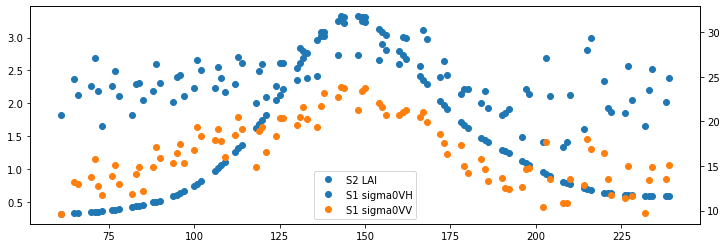

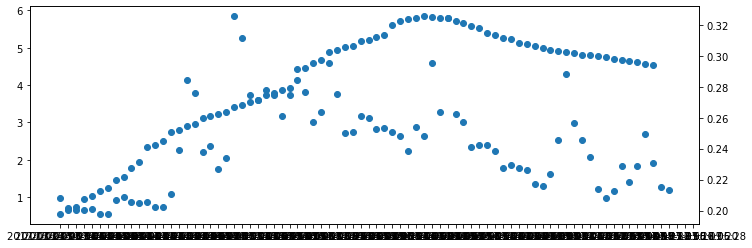

In [3]:
d = np.loadtxt("field_508.txt")
plt.figure(figsize=(12, 4))
doy = d[:, 0]
s2_lai = d[:, 1]
svh = d[:, 2]
svv = d[:, 3]
theta = d[:, 4]
l1 = plt.plot(doy, s2_lai, 'o', label="S2 LAI")
plt.twinx()
l2 = plt.plot(doy, -svh/np.cos(np.deg2rad(theta)), 'o', label="S1 sigma0VH")
l3 = plt.plot(doy, -svv/np.cos(np.deg2rad(theta)), 'o', label="S1 sigma0VV")
legends = l1 + l2 + l3
labels = [l.get_label() for l in legends]
plt.legend(legends, labels, loc="best")

# also load some ground truth

df = pd.read_csv("multi.csv", delimiter=";", skiprows=1)
sel_cols = [x for x in df.columns if x.endswith(".1")]
df = df[sel_cols]

plt.figure(figsize=(12, 4))

plt.plot_date(df["date.1"], df["LAI.1"], 'o')
plt.twinx()
plt.plot_date(df["date.1"], df["SM.1"], 'o')


def to_datetime(date):
    """
    Converts a numpy datetime64 object to a python datetime object 
    Input:
      date - a np.datetime64 object
    Output:
      DATE - a python datetime object
    """
    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return dt.datetime.utcfromtimestamp(timestamp)


field_doy = [int(to_datetime(x).strftime("%j"))
             for x in pd.to_datetime(df["date.1"]).to_numpy()]

That looks reasonably hopeful: there's a clear LAI signal, and with a bit of hope on our side, we can see that the shape of the VV and HH backscatter follows a "similar" trend. We believe that the noise-like variation in the backscatter is due to changes in moisture content (particularly when $LAI\sim 0$), residual speckle, and other environmental factors that result in changes in structure/orientation.

Let's code the previously given expressions and try to fit the data.


In [3]:
def wcm_jac(A, V1, B, V2, C, sigma_soil, theta=23):
    mu = np.cos(np.deg2rad(theta))
    tau = np.exp(-2*B*V2/mu)
    veg = A*V1*(1-tau)
    soil = tau*sigma_soil + C

    der_dA = V1 - V1*tau
    #der_dV1 = A - A*tau
    der_dB = (-2*V2/mu)*tau*(-A*V1 + sigma_soil)
    #der_dV2 = (-2*B/mu)*tau*(-A*V1 + sigma_soil)
    der_dC = 1 # CHECK!!!!!!
    der_dsigmasoil = tau
    return veg+soil, [der_dA, der_dB, der_dC, der_dsigmasoil]
    #return veg + soil, [der_dA, der_dV1, der_dB, der_dV2, der_dC, der_dD, der_dS]

def costf(x, svh, svv, lai, theta, unc=0.5):
    A_vv, B_vv, C_vv, A_vh, B_vh, C_vh = x[:6]
    vsm = x[6:]
    sigma_vv, dvv = wcm_jac(A_vv, lai, B_vv, lai,  C_vv, vsm, theta=theta)
    sigma_vh, dvh  = wcm_jac(A_vh, lai, B_vh, lai, C_vh, vsm, theta=theta)
    diff_vv = (svv - sigma_vv)
    diff_vh = (svh - sigma_vh)
    cost = 0.5*(diff_vv**2 + diff_vh**2)/(unc**2)
    jac = np.concatenate([np.array([np.sum(dvv[0]*diff_vv), 
                             np.sum(dvv[1]*diff_vv), 
                             np.sum(dvv[2]*diff_vv), 
                             #np.sum(dvv[3]*diff_vv), 
                             np.sum(dvh[0]*diff_vh), 
                             np.sum(dvh[1]*diff_vh),
                             np.sum(dvh[2]*diff_vh)]), 
                             #np.sum(dvh[3]*diff_vh)]),
                             dvv[3]*diff_vv + dvh[3]*diff_vh])
    return cost.sum(), -jac/(unc**2)

def fwd_model(x, svh, svv, lai, theta):
    A_vv, B_vv, C_vv, A_vh, B_vh, C_vh = x[:6]
    vsm = x[6:]
    sigma_vv, dvv = wcm_jac(A_vv, lai, B_vv, lai,  C_vv, vsm, theta=theta)
    sigma_vh, dvh  = wcm_jac(A_vh, lai, B_vh, lai, C_vh, vsm, theta=theta)
    return sigma_vv, sigma_vh




We provide some testing to ensure that we've got our signs right and so on...

In [4]:
sigma_soil_vv_mu = np.mean(svv[s2_lai<0.5])
sigma_soil_vv_std = np.std(svv[s2_lai<0.5])
sigma_soil_vh_mu = np.mean(svh[s2_lai<0.5])
sigma_soil_vh_std = np.std(svh[s2_lai<0.5])

# test_jacobian()
xvv = np.array([1, 0.5, sigma_soil_vv_mu ])
xvh = np.array([1, 0.5, sigma_soil_vh_mu])
x0 = np.concatenate([xvv, xvh, np.ones(s2_lai.shape[0])*0.5])

bounds = [[None, None]]*6 + [[-5,5]]*s2_lai.shape[0]

# Check cost function derivative calculations
costf_test = lambda x: costf(x, svh, svv, s2_lai, theta)[0]
d1 = scipy.optimize.approx_fprime(x0, costf_test, 1e-5)
d2 = costf(x0, svh, svv, s2_lai, theta)[1]
print(np.linalg.norm(d1-d2))


0.020722226848319692


Initial cost 7411.53
Final cost 90.3691


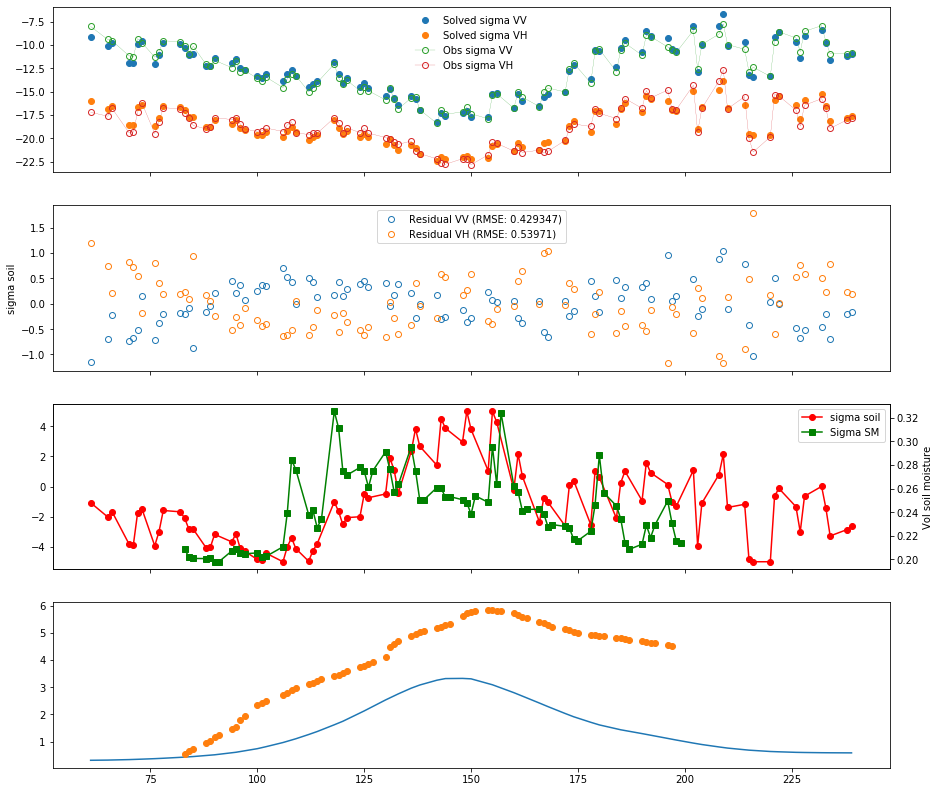

In [8]:
xvv = np.array([1, 0.5, sigma_soil_vv_mu ])
xvh = np.array([1, 0.5, sigma_soil_vh_mu])
x0 = np.concatenate([xvv, xvh, np.ones(s2_lai.shape[0])*0.5])

bounds = [[None, None]]*6 + [[-5,5]]*s2_lai.shape[0]

retval = scipy.optimize.minimize(costf, x0, bounds=bounds,jac=True,
                  args=(svh, svv, s2_lai, theta),
                  tol=1e-10)
print(f"Initial cost {costf(x0,svh, svv, s2_lai,theta)[0]:g}")
print(f"Final cost {retval.fun:g}")

fwd_vv, fwd_vh = fwd_model(retval.x, svh, svv, s2_lai, theta)

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, squeeze=True,
                        figsize=(15,14))
axs = axs.flatten()
l1 = axs[0].plot(doy, fwd_vv, 'o', label="Solved sigma VV")
l2 = axs[0].plot(doy, fwd_vh, 'o', label="Solved sigma VH")

l3 = axs[0].plot(doy, svv, 'o-', mfc="None", lw=0.2, label="Obs sigma VV")
l4 = axs[0].plot(doy, svh, 'o-', mfc="None", lw=0.2, label="Obs sigma VH")
legends = l1+l2+l3+l4
labels = [l.get_label() for l in legends]
axs[0].legend(legends, labels, loc="best", frameon=False)
axs[1].plot(doy, fwd_vv - svv, 'o', mfc="None", label=f"Residual VV (RMSE: {np.std(fwd_vv-svv):g})")
axs[1].plot(doy, fwd_vh - svh, 'o', mfc="None", label=f"Residual VH (RMSE: {np.std(fwd_vh-svh):g})")
axs[1].legend(loc="best")
l1 = axs[2].plot(doy, retval.x[6:], 'r-o', label="sigma soil")
axx = axs[2].twinx()
l2 = axx.plot(field_doy, df["SM.1"], 's-g', label="Sigma SM")
legends = l1 + l2
labels = [l.get_label() for l in legends]
axs[1].set_ylabel("sigma soil")
axx.set_ylabel("Vol soil moisture")
axx.legend(legends, labels, loc="best")
axs[3].plot(doy, s2_lai, '-', label="KaSKA LAI")
axs[3].plot(field_doy, df["LAI.1"], 'o')


Let's see how this worked. Some observations in random order...

* The model is able to fit the data very well (pretty much within the arbitrary uncertainty of 0.5dB chosen). This is a feature: we pass the variation to $\sigma_{soil}$!
* Even so, there are some interesting anticorrelations in the low LAI period between the simulated (solved for) and observed backscatter
* The soil signal shows some passing resemblance to the in situ soil moisture, which is quite interesting and encouraging,
* But that's a similar trend to in situ LAI. This is the bit where having an indicator from canopy moisture content would be helpful, but I didn't extract the data here. In essence, I'm assuming $V_1=V_2=LAI$, whereas while $V_1$ is probably OK, for extinction, relating $V_2=\sqrt{LAI\cdot C_{ab}}$ (assuming this is the moisture volume) might be better.

These points suggest that if we "force" the LAI signal through, we get the soil signal, which appears to show some correlation with soil moisture, but clearly, there's also some shared LAI signal there. Let's see this in a bit more detail below...

0.5123414967445907

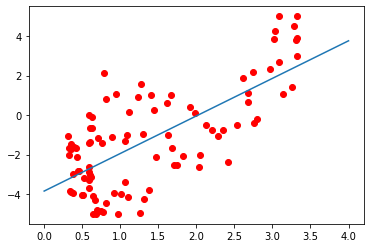

In [6]:
plt.figure()
plt.plot(s2_lai, retval.x[6:], 'or')
#plt.plot(s2_lai, retval.x[8:], 'sk')
fvv = scipy.stats.linregress(s2_lai, retval.x[6:])
fvh = scipy.stats.linregress(svh, retval.x[6:])
xx = np.linspace(0,4,50)
plt.plot(xx, fvv.slope*xx + fvv.intercept, '-')
#plt.plot(xx, fvh.slope*xx + fvh.intercept, '-')
fvv.rvalue**2

0.19994943895452766

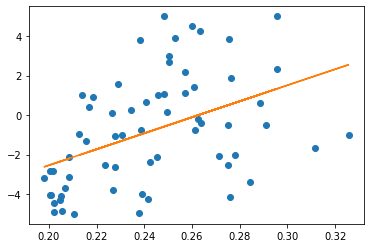

In [7]:
isel_doys = np.array([d for d in field_doy if d in doy])
sel_doys_pos = np.array([list(doy).index(j) for j in isel_doys])
sel_field_doys = np.array([list(field_doy).index(j) for j in isel_doys])

x = df["SM.1"][sel_field_doys]
passer = np.isfinite(x)
x = x[passer]
y = (retval.x[6:])[sel_doys_pos][passer]

ls = scipy.stats.linregress(x,y)

plt.plot(x, y, 'o')
plt.plot(x, x*ls.slope + ls.intercept, '-')

ls.rvalue**2

So LAI explains have of the $\sigma_{soil}$ signal, whereas soil moisture explains $\sim 20\%$. Some simple analysis of how backscatter affects things suggests that if error goes above 0.7 dB, then these relationships (both) disappear, which is kind of interesting.

## Running the WCM with the *in situ* LAI

The above suggests that maybe the S2 LAI data has an important bearing. Let's see how things pan out when we use the *in situ* LAI measurements instead of the S2-derived LAI. We note that the timing/general shape is different, so this could be important. 

We first need to read in the field data and interpolate it to match the observations...

In [23]:
field_lai = np.array(df["LAI.1"])
print("Last field date: ",max(np.array(field_doy)[np.isfinite(field_lai)]))

Last field date:  197


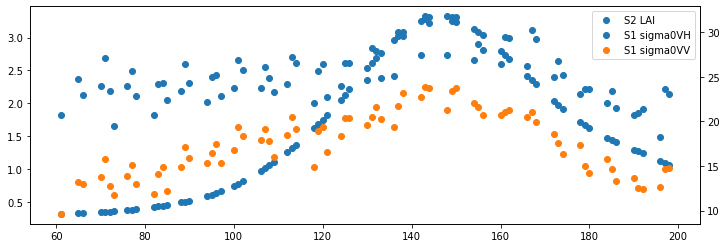

In [43]:
d = np.loadtxt("field_508.txt")
plt.figure(figsize=(12,4))
doy = d[:, 0]
passer = doy <= 198
s2_lai = d[passer,1]
svh = d[passer,2]
svv=d[passer,3]
theta=d[passer,4]
doy = d[passer,0]
l1=plt.plot(doy, s2_lai, 'o', label="S2 LAI")
plt.twinx()
l2=plt.plot(doy, -svh/np.cos(np.deg2rad(theta)), 'o', label="S1 sigma0VH")
l3=plt.plot(doy, -svv/np.cos(np.deg2rad(theta)), 'o', label="S1 sigma0VV")
legends = l1 + l2 + l3
labels  = [l.get_label() for l in legends]
plt.legend(legends, labels,loc="best")



In [44]:
# This is the bit that interpolated the field LAI to the S1 observations
laii= np.interp(doy, np.array(field_doy)[np.isfinite(field_lai)], field_lai[np.isfinite(field_lai)])

Initial cost 13426.5
Final cost 79.9524


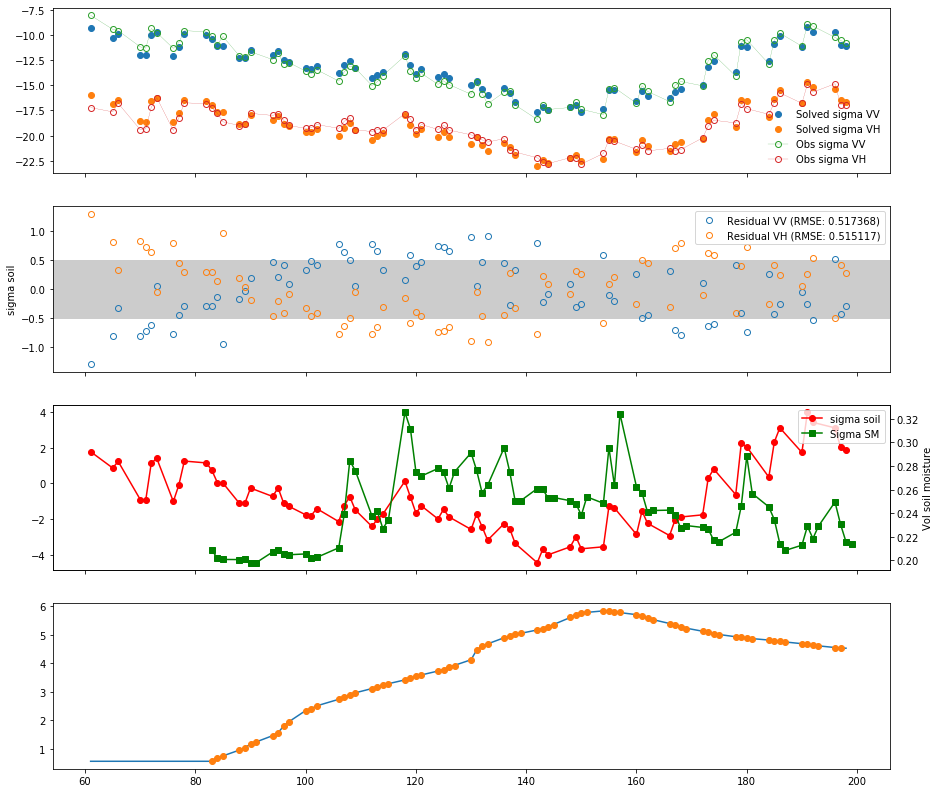

In [48]:
xvv = np.array([1, 0.5, sigma_soil_vv_mu ])
xvh = np.array([1, 0.5, sigma_soil_vh_mu])
x0 = np.concatenate([xvv, xvh, np.ones(laii.shape[0])*0.5])

bounds = [[None, None]]*6 + [[-5,5]]*laii.shape[0]

retval = scipy.optimize.minimize(costf, x0, bounds=bounds,jac=True,
                  args=(svh, svv, laii, theta),
                  tol=1e-10)
print(f"Initial cost {costf(x0,svh, svv, laii,theta)[0]:g}")
print(f"Final cost {retval.fun:g}")

fwd_vv, fwd_vh = fwd_model(retval.x, svh, svv, laii, theta)

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, squeeze=True,
                        figsize=(15,14))
axs = axs.flatten()
l1 = axs[0].plot(doy, fwd_vv, 'o', label="Solved sigma VV")
l2 = axs[0].plot(doy, fwd_vh, 'o', label="Solved sigma VH")

l3 = axs[0].plot(doy, svv, 'o-', mfc="None", lw=0.2, label="Obs sigma VV")
l4 = axs[0].plot(doy, svh, 'o-', mfc="None", lw=0.2, label="Obs sigma VH")
legends = l1+l2+l3+l4
labels = [l.get_label() for l in legends]
axs[0].legend(legends, labels, loc="best", frameon=False)
axs[1].plot(doy, fwd_vv - svv, 'o', mfc="None", label=f"Residual VV (RMSE: {np.std(fwd_vv-svv):g})")
axs[1].plot(doy, fwd_vh - svh, 'o', mfc="None", label=f"Residual VH (RMSE: {np.std(fwd_vh-svh):g})")
axs[1].axhspan(-0.5, 0.5, color="0.8")
axs[1].legend(loc="best")
l1 = axs[2].plot(doy, retval.x[6:], 'r-o', label="sigma soil")
axx = axs[2].twinx()
l2 = axx.plot(field_doy, df["SM.1"], 's-g', label="Sigma SM")
legends = l1 + l2
labels = [l.get_label() for l in legends]
axs[1].set_ylabel("sigma soil")
axx.set_ylabel("Vol soil moisture")
axx.legend(legends, labels, loc="best")
axs[3].plot(doy, laii, '-', label="KaSKA LAI")
axs[3].plot(field_doy, df["LAI.1"], 'o')


0.08555658481243616

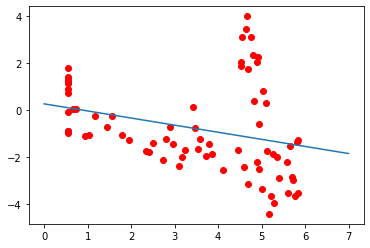

In [42]:
plt.figure()
plt.plot(laii, retval.x[6:], 'or')
#plt.plot(s2_lai, retval.x[8:], 'sk')
fvv = scipy.stats.linregress(laii, retval.x[6:])
fvh = scipy.stats.linregress(svh, retval.x[6:])
xx = np.linspace(0,7,50)
plt.plot(xx, fvv.slope*xx + fvv.intercept, '-')
#plt.plot(xx, fvh.slope*xx + fvh.intercept, '-')
fvv.rvalue**2

0.06423047736889269

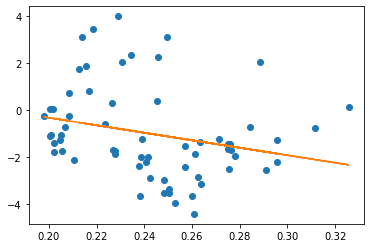

In [49]:
isel_doys = np.array([d for d in field_doy if d in doy])
sel_doys_pos = np.array([list(doy).index(j) for j in isel_doys])
sel_field_doys = np.array([list(field_doy).index(j) for j in isel_doys])

x = df["SM.1"][sel_field_doys]
passer = np.isfinite(x)
x = x[passer]
y = (retval.x[6:])[sel_doys_pos][passer]

ls = scipy.stats.linregress(x,y)

plt.plot(x, y, 'o')
plt.plot(x, x*ls.slope + ls.intercept, '-')

ls.rvalue**2

## Exposing LAI to the solver

We might want to assume that the S2-derived smoothed LAI is not quite as perfect as we said above. We may want to let it float and let the SAR data reach an accommodation with the optical and SAR data. In this case, we need to expose the jacobian of the WCM (mostly done), and calculate the effect of the $V_1$ and $V_2$ parameters in the cost function, as these are where the LAI goes. This is done below.

In [33]:
def wcm_jac(A, V1, B, V2, C, sigma_soil, theta=23):
    """WCM model and jacobian calculations"""
    mu = np.cos(np.deg2rad(theta))
    tau = np.exp(-2*B*V2/mu)
    veg = A*V1*(1-tau)
    soil = tau*sigma_soil + C

    der_dA = V1 - V1*tau
    der_dV1 = A - A*tau
    der_dB = (-2*V2/mu)*tau*(-A*V1 + sigma_soil)
    der_dV2 = (-2*B/mu)*tau*(-A*V1 + sigma_soil)
    der_dC = 1 # CHECK!!!!!!
    der_dsigmasoil = tau
    
    # Also returns der_dV1 and der_dV2
    return veg+soil, [der_dA, der_dB, der_dC,
                      der_dsigmasoil, der_dV1, der_dV2]


def cost_obs(x, svh, svv, theta, unc=0.5):
    """Cost function. Order of parameters is
    A_vv, B_vv, C_vv, A_vh, B_vh, C_vh,
    vsm_0, ..., vsm_N,
    LAI_0, ..., LAI_N
    
    We assume that len(svh) == N
    """
    n_obs = svh.shape[0]
    A_vv, B_vv, C_vv, A_vh, B_vh, C_vh = x[:6]
    vsm = x[6:(6+n_obs)]
    lai = x[(6+n_obs):]
    sigma_vv, dvv = wcm_jac(A_vv, lai, B_vv, lai,  C_vv, vsm, theta=theta)
    sigma_vh, dvh  = wcm_jac(A_vh, lai, B_vh, lai, C_vh, vsm, theta=theta)
    diff_vv = (svv - sigma_vv)
    diff_vh = (svh - sigma_vh)
    cost = 0.5*(diff_vv**2 + diff_vh**2)/(unc**2)
    jac = np.concatenate([np.array([np.sum(dvv[0]*diff_vv), #A_vv
                             np.sum(dvv[1]*diff_vv), # B_vv
                             np.sum(dvv[2]*diff_vv), # C_vv
                             #np.sum(dvv[3]*diff_vv),
                             np.sum(dvh[0]*diff_vh), # A_vh
                             np.sum(dvh[1]*diff_vh), # B_vh
                             np.sum(dvh[2]*diff_vh)]), #C_vh
                             #np.sum(dvh[3]*diff_vh)]),
                             dvv[3]*diff_vv + dvh[3]*diff_vh, # vsm
                             (dvv[4] + dvv[5])*diff_vv + (dvh[4] + dvh[5])*diff_vh # LAI
                             ])  
    return cost.sum(), -jac/(unc**2)

def fwd_model(x, svh, svv, theta):
    n_obs = len(svv)
    A_vv, B_vv, C_vv, A_vh, B_vh, C_vh = x[:6]
    vsm = x[6:(6+n_obs)]
    lai = x[(6+n_obs):]
    sigma_vv, dvv = wcm_jac(A_vv, lai, B_vv, lai,  C_vv, vsm, theta=theta)
    sigma_vh, dvh  = wcm_jac(A_vh, lai, B_vh, lai, C_vh, vsm, theta=theta)
    return sigma_vv, sigma_vh

Let's now test the jacobians, as it's easy to get them wrong.

In [18]:
sigma_soil_vv_mu = np.mean(svv[s2_lai<0.5])
sigma_soil_vv_std = np.std(svv[s2_lai<0.5])
sigma_soil_vh_mu = np.mean(svh[s2_lai<0.5])
sigma_soil_vh_std = np.std(svh[s2_lai<0.5])

# test_jacobian()
xvv = np.array([1, 0.5, sigma_soil_vv_mu ])
xvh = np.array([1, 0.5, sigma_soil_vh_mu])
x0 = np.concatenate([xvv, xvh, np.ones(s2_lai.shape[0])*0.5, s2_lai])

bounds = [[None, None]]*6 + [[-5,5]]*s2_lai.shape[0] + [[0,8]]*s2_lai.shape[0]

# Check cost function derivative calculations
costf_test = lambda x: cost_obs(x, svh, svv, theta)[0]
d1 = scipy.optimize.approx_fprime(x0, costf_test, 1e-6)
d2 = cost_obs(x0, svh, svv,  theta)[1]
print(np.linalg.norm(d1-d2))



xvv = np.array([2.4, 0.1, sigma_soil_vv_mu*1.37 ])
xvh = np.array([1.2, 0.3, sigma_soil_vh_mu/2.3])
x0 = np.concatenate([xvv, xvh, np.ones(s2_lai.shape[0])*0.5, s2_lai])

bounds = [[None, None]]*6 + [[-5,5]]*s2_lai.shape[0] + [[0,8]]*s2_lai.shape[0]

# Check cost function derivative calculations
costf_test = lambda x: cost_obs(x, svh, svv, theta)[0]
d1 = scipy.optimize.approx_fprime(x0, costf_test, 1e-6)
d2 = cost_obs(x0, svh, svv,  theta)[1]
print(np.max(d1-d2), np.min(d1-d2))


0.0020720560317331574
0.00037612583764712326 -0.025462405781581765


In [37]:
def cost_prior(x, svh, svv, theta, prior_mean, prior_unc):
    """Cost function. Order of parameters is
    A_vv, B_vv, C_vv, A_vh, B_vh, C_vh,
    vsm_0, ..., vsm_N,
    LAI_0, ..., LAI_N
    
    We assume that len(svh) == N
    """
    n_obs = len(svh)
    prior_cost = 0.5*(prior_mean-x)**2/prior_unc**2
    dprior_cost = -(prior_mean-x)/prior_unc**2
    dprior_cost[:6] = 0.
    return (prior_cost[6:]).sum(),dprior_cost 
n_obs = len(svv)
prior_mean = np.concatenate([[0,]*6, [0.25,]*n_obs, s2_lai])
prior_sd = np.concatenate([[0,]*6, [0.2,]*n_obs, [0.1,]*n_obs])

xvv = np.array([2.4, 0.1, sigma_soil_vv_mu*1.37 ])
xvh = np.array([1.2, 0.3, sigma_soil_vh_mu/2.3])
x0 = np.concatenate([xvv, xvh, np.ones(s2_lai.shape[0])*0.5, s2_lai])

bounds = [[None, None]]*6 + [[-5,5]]*s2_lai.shape[0] + [[0,8]]*s2_lai.shape[0]

# Check cost function derivative calculations
costf_test = lambda x: cost_prior(x, svh, svv, theta, prior_mean, prior_sd)[0]
d1 = scipy.optimize.approx_fprime(x0, costf_test, 1e-6)
d2 = cost_prior(x0, svh, svv,  theta, prior_mean, prior_sd)[1]

    

/home/ucfajlg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ucfajlg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [85]:
def cost_smooth(x, gamma):

    p_diff1 = x[1:-1] - x[2:]
    p_diff2 = x[1:-1] - x[:-2]
    xcost_model = 0.5*gamma*np.sum(p_diff1**2 + p_diff2**2)
    xdcost_model = 1*gamma*(p_diff1 + p_diff2)
    return xcost_model, xdcost_model


Initial cost 3667.8
Final cost 656.889


/home/ucfajlg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/ucfajlg/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


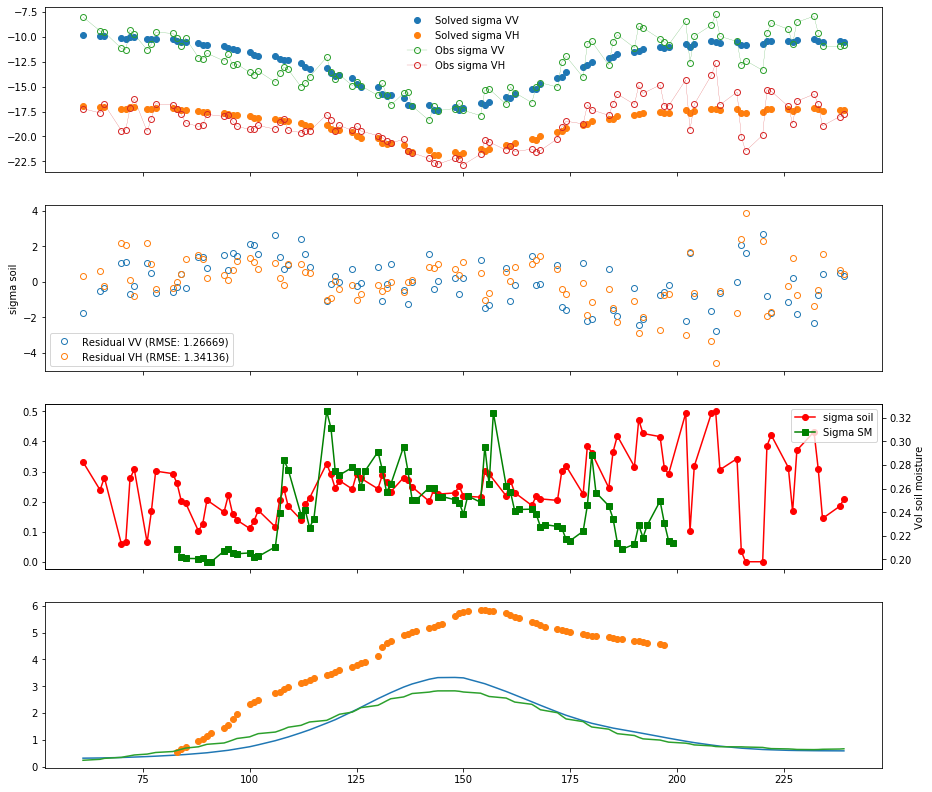

In [94]:
def cost_function(x, svh, svv, theta, gamma, prior_mean, prior_unc, unc=.8):
    cost1, dcost1 = cost_obs(x, svh, svv,  theta, unc=unc)
    cost2, dcost2 = cost_prior(x, svh, svv, theta, prior_mean, prior_unc)
    n_obs = len(svv)
    lai = x[(6+n_obs):]
    
    cost3, dcost3 = cost_smooth(lai, gamma)
    tmp = np.zeros_like(dcost1)
    tmp[(7+n_obs):-1] = dcost3
    return cost1+cost2+cost3, dcost1+dcost2+tmp

n_obs = len(svv)
prior_mean = np.concatenate([[0,]*6, [0.25,]*n_obs, s2_lai])
prior_sd = np.concatenate([[0,]*6, [0.2,]*n_obs, [0.2,]*n_obs])

gamma=1000

xvv = np.array([1, 0.5, sigma_soil_vv_mu ])
xvh = np.array([1, 0.5, sigma_soil_vh_mu])
x0 = np.concatenate([xvv, xvh, np.ones(s2_lai.shape[0])*0.2, s2_lai])


bounds = [[None, None]]*6 + [[0,0.5]]*s2_lai.shape[0] + [[0,8]]*s2_lai.shape[0]

retval = scipy.optimize.minimize(cost_function, x0, bounds=bounds,jac=True,
                  args=(svh, svv, theta, gamma,prior_mean, prior_sd),
                  tol=1e-10)
print(f"Initial cost {cost_function(x0,svh, svv, theta,gamma, prior_mean, prior_sd)[0]:g}")
print(f"Final cost {retval.fun:g}")


fwd_vv, fwd_vh = fwd_model(retval.x, svh, svv, theta)

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, squeeze=True,
                        figsize=(15,14))
axs = axs.flatten()
l1 = axs[0].plot(doy, fwd_vv, 'o', label="Solved sigma VV")
l2 = axs[0].plot(doy, fwd_vh, 'o', label="Solved sigma VH")

l3 = axs[0].plot(doy, svv, 'o-', mfc="None", lw=0.2, label="Obs sigma VV")
l4 = axs[0].plot(doy, svh, 'o-', mfc="None", lw=0.2, label="Obs sigma VH")
legends = l1+l2+l3+l4
labels = [l.get_label() for l in legends]
axs[0].legend(legends, labels, loc="best", frameon=False)
axs[1].plot(doy, fwd_vv - svv, 'o', mfc="None", label=f"Residual VV (RMSE: {np.std(fwd_vv-svv):g})")
axs[1].plot(doy, fwd_vh - svh, 'o', mfc="None", label=f"Residual VH (RMSE: {np.std(fwd_vh-svh):g})")
axs[1].legend(loc="best")
l1 = axs[2].plot(doy, retval.x[6:(n_obs+6)], 'r-o', label="sigma soil")
axx = axs[2].twinx()
l2 = axx.plot(field_doy, df["SM.1"], 's-g', label="Sigma SM")
legends = l1 + l2
labels = [l.get_label() for l in legends]
axs[1].set_ylabel("sigma soil")
axx.set_ylabel("Vol soil moisture")
axx.legend(legends, labels, loc="best")
axs[3].plot(doy, s2_lai, '-', label="KaSKA LAI")
axs[3].plot(field_doy, df["LAI.1"], 'o')
axs[3].plot(doy, retval.x[(n_obs+6):])


/home/ucfajlg/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:193: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


0.4179307780546313

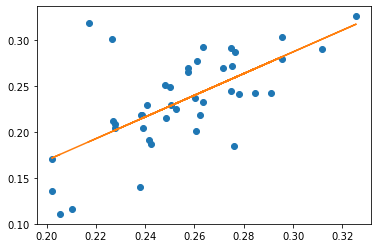

In [97]:
isel_doys = np.array([d for d in field_doy if d in doy])
sel_doys_pos = np.array([list(doy).index(j) for j in isel_doys])
sel_field_doys = np.array([list(field_doy).index(j) for j in isel_doys])

x = df["SM.1"][sel_field_doys]
passer1 = np.isfinite(x)
passer2 = np.logical_and(isel_doys >= 100,
                         isel_doys <= 175)
passer = passer1*passer2
x = x[passer]
y = (retval.x[6:(6+n_obs)])[sel_doys_pos][passer]

ls = scipy.stats.linregress(x,y)

plt.plot(x, y, 'o')
plt.plot(x, x*ls.slope + ls.intercept, '-')

ls.rvalue**2

That's fairly neat: we now explain around ~40% of the variation in soil moisture within the growing period. Results are worse if you go outside the growing period though, suggesting that a better soil backscatter-moisture relationship might be required.